In [1]:
import numpy as np
import pandas as pd
import sklearn

import cv2
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch.cuda.amp import GradScaler, autocast
import torchvision as tv

import os
from os import listdir
from os.path import isfile, join

import wandb
import gc
from tqdm.notebook import tqdm
import ipywidgets as widgets

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
VERSION = 'EfficientNetV2_V1'
BATCH_SIZE = 2
MAX_TRAIN_BATCHES = 305
MAX_VAL_BATCHES = 35
MAX_TEST_BATCHES = 155
NB_EPOCHS = 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_MODEL = True

In [3]:
#Data Labelling
train_img_dir_path = 'images/train'
valid_img_dir_path = 'images/valid'
test_img_dir_path = 'images/test'

train_normal_images = [f'{train_img_dir_path}/normal/{i}' for i in listdir(f'{train_img_dir_path}/normal')]
train_adenocarcinoma_images = [f'{train_img_dir_path}/adenocarcinoma/{i}' for i in listdir(f'{train_img_dir_path}/adenocarcinoma')]
train_largecell_carcinoma_images = [f'{train_img_dir_path}/large.cell.carcinoma/{i}' for i in listdir(f'{train_img_dir_path}/large.cell.carcinoma')]
train_squamouscell_carcinoma_images = [f'{train_img_dir_path}/squamous.cell.carcinoma/{i}' for i in listdir(f'{train_img_dir_path}/squamous.cell.carcinoma')]

print(len(train_normal_images),len(train_adenocarcinoma_images),
      len(train_largecell_carcinoma_images),len(train_squamouscell_carcinoma_images))

valid_normal_images = [f'{valid_img_dir_path}/normal/{i}' for i in listdir(f'{valid_img_dir_path}/normal')]
valid_adenocarcinoma_images = [f'{valid_img_dir_path}/adenocarcinoma/{i}' for i in listdir(f'{valid_img_dir_path}/adenocarcinoma')]
valid_largecell_carcinoma_images = [f'{valid_img_dir_path}/large.cell.carcinoma/{i}' for i in listdir(f'{valid_img_dir_path}/large.cell.carcinoma')]
valid_squamouscell_carcinoma_images = [f'{valid_img_dir_path}/squamous.cell.carcinoma/{i}' for i in listdir(f'{valid_img_dir_path}/squamous.cell.carcinoma')]

print(len(valid_normal_images),len(valid_adenocarcinoma_images ),
      len(valid_largecell_carcinoma_images),len(valid_squamouscell_carcinoma_images))

test_normal_images = [f'{test_img_dir_path}/normal/{i}' for i in listdir(f'{test_img_dir_path}/normal')]
test_adenocarcinoma_images = [f'{test_img_dir_path}/adenocarcinoma/{i}' for i in listdir(f'{test_img_dir_path}/adenocarcinoma')]
test_largecell_carcinoma_images = [f'{test_img_dir_path}/large.cell.carcinoma/{i}' for i in listdir(f'{test_img_dir_path}/large.cell.carcinoma')]
test_squamouscell_carcinoma_images = [f'{test_img_dir_path}/squamous.cell.carcinoma/{i}' for i in listdir(f'{test_img_dir_path}/squamous.cell.carcinoma')]

print(len(test_normal_images),len(test_adenocarcinoma_images),
      len(test_largecell_carcinoma_images),len(test_squamouscell_carcinoma_images))

#We can see that the datasets are balanced

148 195 115 155
13 23 21 15
54 120 51 90


In [4]:
train_cancer_df = pd.DataFrame(columns=['image_id','label'])
val_cancer_df = pd.DataFrame(columns=['image_id','label'])
test_cancer_df = pd.DataFrame(columns=['image_id','label'])

train_cancer_df['image_id'] = train_normal_images + train_adenocarcinoma_images + train_largecell_carcinoma_images + train_squamouscell_carcinoma_images
train_cancer_df['label'] = np.zeros_like(train_normal_images,dtype=int).tolist()+np.ones_like(train_adenocarcinoma_images,dtype=int).tolist()+np.full_like(train_largecell_carcinoma_images,2,dtype=int).tolist()+np.full_like(train_squamouscell_carcinoma_images,3,dtype=int).tolist()
val_cancer_df['image_id'] = valid_normal_images + valid_adenocarcinoma_images + valid_largecell_carcinoma_images + valid_squamouscell_carcinoma_images 
val_cancer_df['label'] = np.zeros_like(valid_normal_images,dtype=int).tolist() + np.ones_like(valid_adenocarcinoma_images,dtype=int).tolist() + np.full_like(valid_largecell_carcinoma_images,2,dtype=int).tolist() + np.full_like(valid_squamouscell_carcinoma_images,3,dtype=int).tolist()
test_cancer_df['image_id'] = test_normal_images + test_adenocarcinoma_images + test_largecell_carcinoma_images + test_squamouscell_carcinoma_images
test_cancer_df['label'] = np.zeros_like(test_normal_images,dtype=int).tolist() + np.ones_like(test_adenocarcinoma_images,dtype=int).tolist() + np.full_like(test_largecell_carcinoma_images,2,dtype=int).tolist() + np.full_like(test_squamouscell_carcinoma_images,3,dtype=int).tolist()

In [5]:
train_cancer_df.head()

,image_id,label
0,images/train/normal/19 - Copy.png,0
1,images/train/normal/11 - Copy (2) - Copy.png,0
2,images/train/normal/n6 - Copy.jpg,0
3,images/train/normal/7.png,0
4,images/train/normal/16 - Copy.png,0


In [6]:
print(len(train_cancer_df),len(val_cancer_df),len(test_cancer_df))

613 72 315


In [7]:
val_cancer_df.head(15)

,image_id,label
0,images/valid/normal/7.png,0
1,images/valid/normal/6 - Copy (3).png,0
2,images/valid/normal/004007_01_01_519.png,0
3,images/valid/normal/7 - Copy (2).png,0
4,images/valid/normal/6 - Copy.png,0
5,images/valid/normal/4 (2).png,0
6,images/valid/normal/003828_02_01_174.png,0
7,images/valid/normal/4 - Copy (2).png,0
8,images/valid/normal/5.png,0
9,images/valid/normal/004162_01_01_150.png,0


In [8]:
class LungsCancerDetectionDataset(Dataset):
    def __init__(self, annotations_file,transform=None, target_transform=None):
        self.img_labels = annotations_file
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = str(self.img_labels.iloc[idx].image_id)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (400,400))
        image = np.transpose(image, (2, 0, 1))
        image = torch.as_tensor(image)
        image = image.float()
        image = image/255
        label = torch.as_tensor(self.img_labels.iloc[idx].label)
        return image, label

In [9]:
class LungsCancerDetectionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = tv.models.efficientnet_v2_s()
        self.nn_detection = torch.nn.Sequential(
            torch.nn.Linear(1000,4)
        )

    def forward(self, x):
        x = self.model(x)
        logits = self.nn_detection(x)
        return logits
    
    def predict(self,logits):
        preds = self.forward(logits)
        preds = torch.sigmoid(preds)
        return preds

In [10]:
def save_model(name, model):
    torch.save(model.state_dict(), f'{name}.tph')

def load_model(model, name, path='.'):
    data = torch.load(os.path.join(path, f'{name}.tph'))
    model.load_state_dict(data)
    return model

def gc_collect():
    gc.collect()
    torch.cuda.empty_cache()

In [11]:
def train_model(ds_train, logger, name):
    
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True,num_workers=os.cpu_count())
    model = LungsCancerDetectionModel().to(DEVICE)
    optim = torch.optim.Adam(model.parameters())
    
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=0.003, epochs=NB_EPOCHS,
                                                steps_per_epoch=min(MAX_TRAIN_BATCHES, len(dl_train)),
                                                pct_start=0.3)
    model.train()
    scaler = GradScaler()
    
    for epoch in tqdm(range(NB_EPOCHS), desc='Epoch'):
        with tqdm(dl_train, desc='Train') as progress:

            for batch_idx, (X, y) in enumerate(progress):

                if batch_idx >= MAX_TRAIN_BATCHES:
                    save_model(name, model)
                    break

                optim.zero_grad()
                with autocast():
                    pred = model.forward(X.to(DEVICE))
                    pred = pred.squeeze()
                    loss = torch.nn.functional.cross_entropy(pred,y.to(DEVICE))

                    if np.isinf(loss.item()) or np.isnan(loss.item()):
                        print(f'Bad loss, skipping the batch {batch_idx}')
                        del loss, pred
                        gc_collect()
                        continue

                scaler.scale(loss).backward()
                scaler.step(optim)
                scaler.update()
                scheduler.step()

                logger.log({'training loss': (loss.item()),
                            'learning rate': scheduler.get_last_lr()[0],
                            'epoch': epoch})
                
    save_model(name, model)
    return model

In [12]:
if TRAIN_MODEL == True :
    with wandb.init(project='DS50', name=VERSION) as run:
        gc_collect()
        ds_train = LungsCancerDetectionDataset(train_cancer_df)
        model = train_model(ds_train,run,VERSION)
else:
    model = load_model(LungsCancerDetectionModel().to(DEVICE),"DenseNet_V2")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rbizet. Use `wandb login --relogin` to force relogin


/home/rbizet/Desktop/DS50/DS50Env/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/307 [00:00<?, ?it/s]

/home/rbizet/Desktop/DS50/DS50Env/lib/python3.9/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Train:   0%|          | 0/307 [00:00<?, ?it/s]

Train:   0%|          | 0/307 [00:00<?, ?it/s]

Train:   0%|          | 0/307 [00:00<?, ?it/s]

epoch,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆██████████
learning rate,▁▁▂▂▃▄▅▆▇▇███████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁
training loss,▃█▁▃▂▄▆▄▄▃▄▄▇▄▄▄▄▃▅▄▄▃▄▄▅▄▅▄▄▄▄▄▄▃▅▂▂▃▂▄
epoch,3
learning rate,0.0
training loss,1.16088


In [13]:
def evaluate_model(model, ds, max_batches):
    model = model.to(DEVICE)
    dl_val = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False)
    preds = []
    labels = []
    with torch.no_grad():
        model.eval()
        losses = []
        with tqdm(dl_val, desc='Val') as progress:
            for i, (X, y) in enumerate(progress):
                with autocast():
                    pred = model.forward(X.to(DEVICE))
                    pred = pred.squeeze()
                    loss = torch.nn.functional.cross_entropy(pred,y.to(DEVICE))
                    pred = torch.sigmoid(pred)
                    preds.append(pred.cpu())
                    losses.append(loss)
                    labels.append(y.cpu().numpy())
                    
                if i >= max_batches:
                    break
        preds = torch.concat(preds).cpu().numpy()
        labels = np.concatenate(labels)
        return np.mean(losses), preds

Val:   0%|          | 0/36 [00:00<?, ?it/s]

Val loss 16.878721237182617


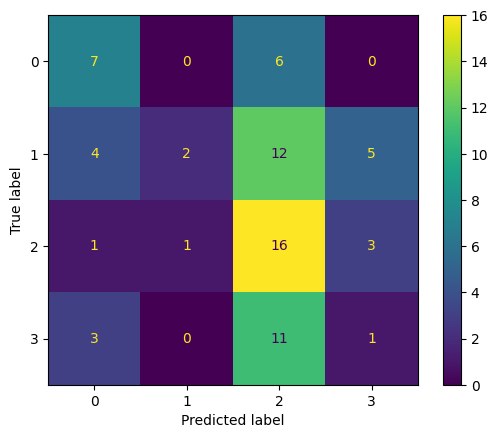

Accuracy on validation dataset: 0.3611111111111111


In [14]:
def gen_model_predictions(model, val_cancer_df, max_batches):
    ds_eval = LungsCancerDetectionDataset(val_cancer_df)
    loss, preds = evaluate_model(model, ds_eval, max_batches)
    df_pred = pd.DataFrame(data=preds,columns=['normal','adenocarcinoma','largecell_carcinoma','squamouscell_carcinoma'])
    df_train_predictions = pd.concat(
            [val_cancer_df.head(len(df_pred)).reset_index(drop=True),df_pred],axis=1
    )
    return df_train_predictions,loss

val_df_pred, val_loss = gen_model_predictions(model,val_cancer_df,MAX_VAL_BATCHES)
print(f'Val loss {val_loss}')
val_df_pred.to_csv(f'val_predictions_{VERSION}.csv', index=False)

final_val_df_pred = val_df_pred[['normal','adenocarcinoma','largecell_carcinoma','squamouscell_carcinoma']]
final_val_df_pred = final_val_df_pred.rename({'normal': 0, 'adenocarcinoma': 1,
                          'largecell_carcinoma': 2,'squamouscell_carcinoma': 3}, axis=1)
final_val_df_pred = final_val_df_pred.idxmax(axis=1)

cm_val = confusion_matrix(val_df_pred['label'],final_val_df_pred)
disp_cm_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp_cm_val.plot()
plt.show()

val_correct_predictions = cm_val.diagonal().sum()
val_total_samples = cm_val.sum()
val_accuracy = val_correct_predictions / val_total_samples
print("Accuracy on validation dataset:", val_accuracy)

Val:   0%|          | 0/158 [00:00<?, ?it/s]

/home/rbizet/Desktop/DS50/DS50Env/lib/python3.9/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Test loss 29.11736297607422


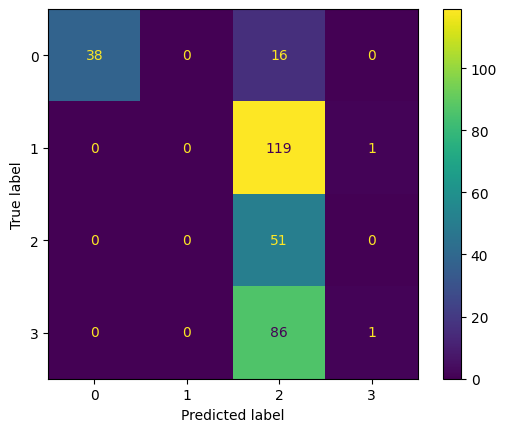

Accuracy on test dataset: 0.28846153846153844


In [15]:
test_df_pred, test_loss = gen_model_predictions(model,test_cancer_df,MAX_TEST_BATCHES)
print(f'Test loss {test_loss}')
test_df_pred.to_csv(f'test_predictions_{VERSION}.csv', index=False)

final_test_df_pred = test_df_pred[['normal','adenocarcinoma','largecell_carcinoma','squamouscell_carcinoma']]
final_test_df_pred = final_test_df_pred.rename({'normal': 0, 'adenocarcinoma': 1,
                          'largecell_carcinoma': 2,'squamouscell_carcinoma': 3}, axis=1)
final_test_df_pred = final_test_df_pred.idxmax(axis=1)

cm_test = confusion_matrix(test_df_pred['label'],final_test_df_pred)
disp_cm_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_cm_test.plot()
plt.show()

test_correct_predictions = cm_test.diagonal().sum()
test_total_samples = cm_test.sum()
test_accuracy = test_correct_predictions / test_total_samples
print("Accuracy on test dataset:", test_accuracy)